In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus=tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)


# Removal of Unreadable images

In [ ]:
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/ML-ImageClassification/Dataset/orignal'
img_ext=['jpg','jpeg','bmp','png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_ext:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# Loading the data

In [ ]:
data=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(224, 224))

Found 23610 files belonging to 10 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()


In [ ]:
batch = data_iterator.next()
'''
0 = Battery
1 = Biological
2 = Cardboard
3 = Clothes
4 = Glass
5 = Metal
6 = Paper
7 = Plastic
8 = Shoes
9 = Trash
'''


'\n0 = Battery\n1 = Biological\n2 = Cardboard\n3 = Clothes\n4 = Glass\n5 = Metal\n6 = Paper\n7 = Plastic\n8 = Shoes\n9 = Trash\n'

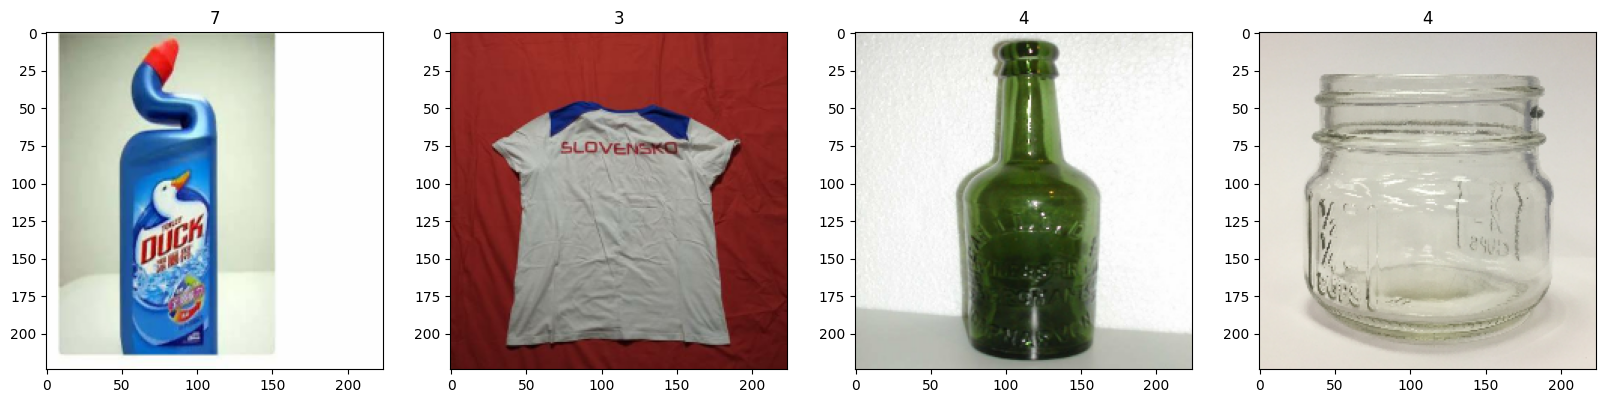

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Pre-Processing Images

In [ ]:
def preprocess_data(image, label):
    image = image / 255.0
    label = tf.one_hot(label, depth=10)
    return image, label

In [ ]:
data = data.map(preprocess_data)

# Splitting the Data

In [ ]:
len(data)

738

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train_size+ val_size+ test_size

738

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Building the VGG-19 Model

* Importing Neccesary libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

In [ ]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD,Adam

# Load pre-trained VGG-19 model without top layers
base_model = VGG19(include_top=False, input_shape=(224, 224, 3))

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=(7*7*512,)))  # Define input shape for Flatten layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                                 
Total params: 20275274 (77.34 MB)
Trainable params: 20275274 (77.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the model

In [ ]:
logdir='/content/drive/MyDrive/Colab Notebooks/ML-ImageClassification/logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
516/516 [==============================] - 198s 345ms/step - loss: 2.0454 - accuracy: 0.2951 - val_loss: 1.9155 - val_accuracy: 0.3505
Epoch 2/30
516/516 [==============================] - 179s 346ms/step - loss: 1.7414 - accuracy: 0.3910 - val_loss: 1.6490 - val_accuracy: 0.4227
Epoch 3/30
516/516 [==============================] - 178s 344ms/step - loss: 1.5181 - accuracy: 0.4640 - val_loss: 1.4491 - val_accuracy: 0.4854
Epoch 4/30
516/516 [==============================] - 177s 342ms/step - loss: 1.3934 - accuracy: 0.5170 - val_loss: 1.3359 - val_accuracy: 0.5446
Epoch 5/30
516/516 [==============================] - 177s 342ms/step - loss: 1.2702 - accuracy: 0.5631 - val_loss: 1.2883 - val_accuracy: 0.5627
Epoch 6/30
516/516 [==============================] - 177s 342ms/step - loss: 1.1878 - accuracy: 0.5948 - val_loss: 1.2283 - val_accuracy: 0.5925
Epoch 7/30
516/516 [==============================] - 177s 342ms/step - loss: 1.0809 - accuracy: 0.6310 - val_loss: 1.2243 -

# Plotting The performance of the model

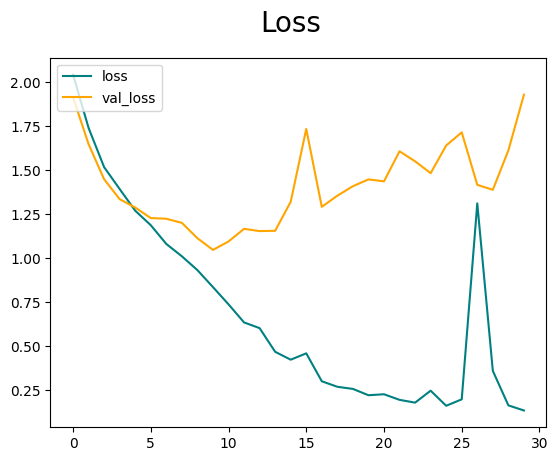

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

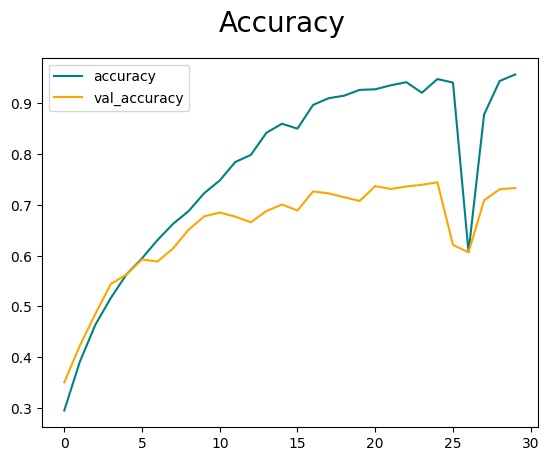

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


# Evaluating the Model with Metrics

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 4s 4s/step


In [ ]:
print("Accuracy is ",acc.result().numpy())
print("Precision is ",pre.result().numpy())
print("Recall is ",re.result().numpy())


Accuracy is  0.9478831
Precision is  0.7457627
Recall is  0.72650295


# Trial On New Image

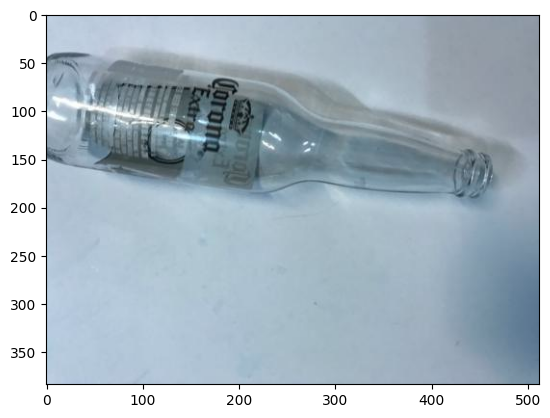

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/ML-ImageClassification/Dataset/Trial/test/glass/glass104.jpg')
plt.imshow(img)
plt.show()

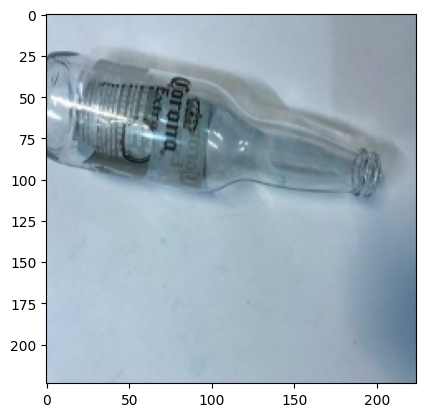

In [ ]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 1s 642ms/step


array([[4.0432185e-04, 9.5956608e-08, 5.4752390e-04, 4.7131339e-09,
        5.7586610e-01, 8.0587221e-03, 1.6849259e-01, 2.4662979e-01,
        3.1326795e-07, 5.9982210e-07]], dtype=float32)

In [ ]:
predicted_class_index = np.argmax(yhat)
class_dict={
    0 : 'Battery',
1 : 'Biological',
2 : 'Cardboard',
3 : 'Clothes',
4 : 'Glass',
5 : 'Metal',
6 : 'Paper',
7 : 'Plastic',
8 : 'Shoes',
9 : 'Trash'
}
print("The images is ",class_dict[predicted_class_index])

The images is  Glass


# Saving the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/ML-ImageClassification/models','gbgclassifier2.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
